Data-Duplication-Removal-Using-Machine-Learning (Hash)


In [ ]:
import pandas as pd
import numpy as np
import time
import os

from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

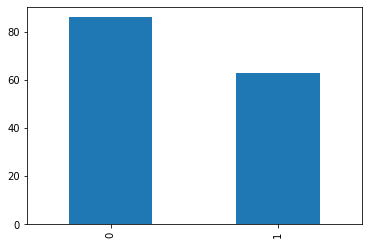

In [ ]:
data = pd.read_csv('Input.csv')
data['is_duplicate'].value_counts().plot(kind='bar')

In [ ]:
data

ln  ...                         hash
0        SMITH JR  ...  b'wKkNy25BkUeZf06o2jJ6zw=='
1    ROTHMEYER JR  ...  b'N2hmeSlSkC0bi/kbID2YdA=='
2       BLAND III  ...  b'LTt/hA+lZH7xu0hhuwL5og=='
3        BLAND JR  ...  b'pQf0T22zXX76fYM0LCLMVg=='
4           BLAND  ...  b'XhFtQh04LCumDBUz5FGfxA=='
..            ...  ...                          ...
144       PRERNA   ...  b'bsmW2CluyQ7Ba5uEME6zUw=='
145       PRERNA   ...  b'f0IxWQjtGKG3MXyyGn4jSw=='
146       PRERNA   ...  b'f0IxWQjtGKG3MXyyGn4jSw=='
147        ANSHUL  ...  b'tqmBk9VgA3Ea/uCzrbTN5w=='
148        ANSHUL  ...  b'F79AYm0xzlVm1Hf5Pg+pjQ=='

[149 rows x 8 columns]

In [ ]:
data.head()

ln         dob gn       fn  is_duplicate
0      SMITH JR  01-03-1968  F  WILLIAM             0
1  ROTHMEYER JR  01-03-1968  F  WILLIAM             0
2     BLAND III  21-02-1962  F  WILLIAM             1
3      BLAND JR  21-02-1962  F     BILL             0
4         BLAND  21-02-1962  F  WILLIAM             1

In [ ]:
#### The dob is converted to standard datetime format.

data.dob = pd.to_datetime(data.dob)

In [ ]:
data.head()

ln        dob gn       fn  is_duplicate
0      SMITH JR 1968-01-03  F  WILLIAM             0
1  ROTHMEYER JR 1968-01-03  F  WILLIAM             0
2     BLAND III 1962-02-21  F  WILLIAM             1
3      BLAND JR 1962-02-21  F     BILL             0
4         BLAND 1962-02-21  F  WILLIAM             1

In [ ]:
data.dob.head(10)

0   1968-01-03
1   1968-01-03
2   1962-02-21
3   1962-02-21
4   1962-02-21
5   1962-02-21
6   1954-08-06
7   1954-08-06
8   1953-10-25
9   1953-10-25
Name: dob, dtype: datetime64[ns]

In [ ]:
data['name'] = data.fn + ' ' + data.ln

In [ ]:
import hashlib
import base64
data = data.assign(concat  = data.dob.astype(str) + data.gn + data.fn + data.ln)
data['hash']=data['concat'].astype(str).str.encode('UTF-8').apply(lambda x: base64.b64encode(hashlib.md5(x).digest()))
data
#data2=data
data.head()

ln  ...                         hash
0      SMITH JR  ...  b'wKkNy25BkUeZf06o2jJ6zw=='
1  ROTHMEYER JR  ...  b'N2hmeSlSkC0bi/kbID2YdA=='
2     BLAND III  ...  b'LTt/hA+lZH7xu0hhuwL5og=='
3      BLAND JR  ...  b'pQf0T22zXX76fYM0LCLMVg=='
4         BLAND  ...  b'XhFtQh04LCumDBUz5FGfxA=='

[5 rows x 8 columns]

In [ ]:
#### A list of unique dates of birth and unique genders is obtained.

unique_dob = data.dob.unique()
unique_sex = data.gn.unique()
unique_hash = data.hash.unique()

In [ ]:
pip install Distance

     |████████████████████████████████| 180 kB 15.3 MB/s 
  Created wheel for Distance: filename=Distance-0.1.3-py3-none-any.whl size=16275 sha256=c3a35db04f1031eec973db9fec0a3ffeeef3afcd62d970ca69e5894e3e674464
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built Distance


In [ ]:
import distance

In [ ]:
### Deduplication model function. This function learns by evaluating the Macro F1-score of classification on a passed range of values for maximum levenshtein score to classify an entry as duplicate.
start_h= time.time()

def deduplication_model(data, scoring_range = 10, step = 2):
    data['indices'] = list(range(len(data)))
    accuracy = []
    index = []
    final_step = 0
    for value in range(scoring_range):
        for i in unique_dob:
            for j in unique_sex:
                sample = data[(data.dob == i)][(data.gn == j)].reset_index(drop = True)
                for a in range(len(sample)):
                    comparison = sample[(sample.indices != sample.indices[a])].reset_index(drop = True)
                    scores = [distance.levenshtein(sample.name[a], comparison.name[x]) for x in range(len(comparison))]
                    compare = [comparison.indices[x] for x in range(len(comparison))]
                    try:
                        if sample.indices[a]>compare[scores.index(min(scores))]:
                            score = np.min(scores)
                            if score<=value:
                                index.append(sample.indices[a])
                    except ValueError:
                        pass
        prediction = []
        for k in range(len(data)):
            if data.indices[k] in index:
                prediction.append(1)
            else:
                prediction.append(0)

        data['prediction'] = prediction
        print('F1-score after ',value, 'iterations : ', f1_score(data.is_duplicate, data.prediction, average = 'macro'))
        accuracy.append(f1_score(data.is_duplicate, data.prediction, average = 'macro'))
        if len(accuracy)>1 and accuracy[-1] <= accuracy[-2]:
            final_step+=1
        if final_step>=step:    
            value = value-final_step
            break
    
    index = []
    for i in unique_dob:
        for j in unique_sex:
            sample = data[(data.dob == i)][(data.gn == j)].reset_index(drop = True)
            for a in range(len(sample)):
                comparison = sample[(sample.indices != sample.indices[a])].reset_index(drop = True)
                scores = [distance.levenshtein(sample.name[a], comparison.name[x]) for x in range(len(comparison))]
                compare = [comparison.indices[x] for x in range(len(comparison))]
                try:
                    if sample.indices[a]>compare[scores.index(min(scores))]:
                        score = np.min(scores)
                        if score<=value:
                            index.append(sample.indices[a])
                except ValueError:
                    pass
    prediction = []
    for k in range(len(data)):
        if data.indices[k] in index:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction, value

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.05, stratify = data.is_duplicate, random_state = 0)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)
performance, levenshtein_value_optimum = deduplication_model(train, scoring_range = 10, step = 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local

F1-score after  0 iterations :  0.6611481975967958


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local

F1-score after  1 iterations :  0.6825155783630937


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local

F1-score after  2 iterations :  0.6778147071042793


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local

F1-score after  3 iterations :  0.6663580246913581


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local

F1-score after  4 iterations :  0.6335796178343949


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

In [ ]:
def deduplication_prediction(data, optimum_value):
    data['indices'] = list(range(len(data)))
    index = []
    for i in unique_dob:
        for j in unique_sex:
            sample = data[(data.dob == i)][(data.gn == j)].reset_index(drop = True)
            for a in range(len(sample)):
                comparison = sample[(sample.indices != sample.indices[a])].reset_index(drop = True)
                scores = [distance.levenshtein(sample.name[a], comparison.name[x]) for x in range(len(comparison))]
                compare = [comparison.indices[x] for x in range(len(comparison))]
                try:
                    if sample.indices[a]>compare[scores.index(min(scores))]:
                        score = np.min(scores)
                        if score<=optimum_value:
                            index.append(sample.indices[a])
                except ValueError:
                    pass
    prediction = []
    for k in range(len(data)):
        if data.indices[k] in index:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction

In [ ]:
predictions = deduplication_prediction(test, levenshtein_value_optimum)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  

In [ ]:
print('F1-score on test set:',accuracy_score(test.is_duplicate, predictions))


F1-score on test set: 0.625


In [ ]:
train['prediction'] = performance
test['prediction'] = predictions
dataset = pd.concat([train, test], axis = 0)
dataset = dataset[(dataset.prediction != 1)].reset_index(drop = True).drop(labels = ['name', 'is_duplicate', 'prediction', 'indices'], axis = 1)

In [ ]:
dataset.to_csv('output1.csv', index = False)
end_h = time.time()
tt2 = end_h - start_h
print('Time taken: ')
tt2

Time taken: 


60.23297142982483

In [ ]:
data1 = pd.read_csv('output1.csv')
data1.head()

ln  ...                         hash
0  GRIFFIN JR  ...  b'EQynjeNAdMSOAU36BUwvPA=='
1    SHAILEE   ...  b'LNcw29ntnSEibJHUbg204g=='
2   LARSON JR  ...  b'Z2LoJV0dBqXm2eTH4WMsaQ=='
3    DEEPIKA   ...  b'0/NYy6DojfiDzFZQa121Qg=='
4     LIND JR  ...  b'OGok+EeZ6LndZ52lT0nQBw=='

[5 rows x 6 columns]

In [ ]:
data1

ln  ...                         hash
0   GRIFFIN JR  ...  b'EQynjeNAdMSOAU36BUwvPA=='
1     SHAILEE   ...  b'LNcw29ntnSEibJHUbg204g=='
2    LARSON JR  ...  b'Z2LoJV0dBqXm2eTH4WMsaQ=='
3     DEEPIKA   ...  b'0/NYy6DojfiDzFZQa121Qg=='
4      LIND JR  ...  b'OGok+EeZ6LndZ52lT0nQBw=='
..         ...  ...                          ...
91  GRIFFIN JR  ...  b'OxMT5FFSNsJ1W7UYpIY1Dg=='
92         RAJ  ...  b'z90E3U9EewPdVklwCsaOKw=='
93   SALTER JR  ...  b'C/nkx7UR9QEB55yKI4sRPg=='
94   MELVIN JR  ...  b'YEBnvjKGoB5D/Tt584W95Q=='
95   BLAND III  ...  b'LTt/hA+lZH7xu0hhuwL5og=='

[96 rows x 6 columns]